In [1]:
!pip install bsuite
!pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from bsuite import sweep
import warnings
from scipy.stats import ttest_ind
import seaborn as sns

sns.set_style("whitegrid")

In [3]:
def get_experiments_df(memory_models, envs, seeds, save_dir, column_names):
    df_data = []
    for seed in seeds:
        for memory in memory_models:
            for env in envs:
                env_id_list = get_sweep_from_bsuite_id(env)
                for env_id in env_id_list:
                    env_id = env_id.replace("/", "-")
                    path_to_file = f"results/{seed}/{memory}/data/{save_dir}/{env_id}_log.csv"
                    if not os.path.exists(path_to_file):
                        warnings.warn(f"Path {path_to_file} doesn't exist. Skipping.")
                        continue
                    data = pd.read_csv(
                        path_to_file,
                        names=column_names,
                        index_col=None,
                        header=0,
                    )
                    data["Seed"] = seed
                    data["Memory"] = memory
                    data["Experiment"] = int(env_id.split("-")[-1])
                    data["Environment"] = env_id.split("-")[0]
                    df_data.append(data)
    df = pd.concat(df_data, axis=0, ignore_index=True)
    return df

In [4]:
def get_sweep_from_bsuite_id(bsuite_id: str):
    return {
        "memory_len": sweep.MEMORY_LEN,
        "memory_size": sweep.MEMORY_SIZE,
    }.get(bsuite_id, [bsuite_id])

## Memory Size Experiments 

In [5]:
memory_models = ["GTrXL", "Integrated Transformer", "LSTM"]
envs = ["memory_size/4", "memory_size/9"]
seeds = [4, 5, 10, 92, 82, 35, 31, 79, 86, 24, 88, 55, 16, 90, 30, 60, 64, 42, 75, 83, 11, 52, 61, 57, 94, 39, 47, 49, 65, 81]

In [6]:
experiments = get_experiments_df(
    memory_models,
    envs,
    seeds,
    save_dir="eval",
    column_names=["Episode", "Average Score"],
)

In [7]:
experiments.head()

,Episode,Average Score,Seed,Memory,Experiment,Environment
0,100.0,0.02,4,GTrXL,4,memory_size
1,100.0,0.00,4,GTrXL,9,memory_size
2,100.0,0.16,4,Integrated Transformer,4,memory_size
3,100.0,0.00,4,Integrated Transformer,9,memory_size
4,100.0,0.42,4,LSTM,4,memory_size


## T-Tests 

### Memory Size 4

In [14]:
memory_1 = experiments[(experiments['Memory']=="LSTM") & (experiments['Experiment']==4)]
memory_2 = experiments[(experiments['Memory']=="GTrXL") & (experiments['Experiment']==4)]

stat, p = ttest_ind(memory_1['Average Score'], memory_2['Average Score'], equal_var=False)
print("Context Size 5: LSTM vs GTrXL ")
print('T-Stat=%.3f, p=%.3f' % (stat, p))

Context Size 5: LSTM vs GTrXL 
T-Stat=5.938, p=0.000


In [15]:
memory_1 = experiments[(experiments['Memory']=="LSTM") & (experiments['Experiment']==4)]
memory_2 = experiments[(experiments['Memory']=="Integrated Transformer") & (experiments['Experiment']==4)]

stat, p = ttest_ind(memory_1['Average Score'], memory_2['Average Score'], equal_var=False)
print("Context Size 5: LSTM vs Integrated Transformer ")
print('T-Stat=%.3f, p=%.3f' % (stat, p))

Context Size 5: LSTM vs Integrated Transformer 
T-Stat=3.327, p=0.002


## Memory Size 9

In [16]:
memory_1 = experiments[(experiments['Memory']=="LSTM") & (experiments['Experiment']==9)]
memory_2 = experiments[(experiments['Memory']=="GTrXL") & (experiments['Experiment']==9)]

stat, p = ttest_ind(memory_1['Average Score'], memory_2['Average Score'], equal_var=False)
print("Context Size 10: LSTM vs GTrXL ")
print('T-Stat=%.3f, p=%.3f' % (stat, p))

Context Size 10: LSTM vs GTrXL 
T-Stat=4.171, p=0.000


In [17]:
memory_1 = experiments[(experiments['Memory']=="LSTM") & (experiments['Experiment']==9)]
memory_2 = experiments[(experiments['Memory']=="Integrated Transformer") & (experiments['Experiment']==9)]

stat, p = ttest_ind(memory_1['Average Score'], memory_2['Average Score'], equal_var=False)
print("Context Size 10: LSTM vs Integrated Transformer ")
print('T-Stat=%.3f, p=%.3f' % (stat, p))

Context Size 10: LSTM vs Integrated Transformer 
T-Stat=3.476, p=0.001


# Seed Sensitivity 

## Memory Size 4

In [18]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_style("whitegrid")

In [19]:
memory_models = ["LSTM", "GTrXL", "Universal Transformer", "Integrated Transformer", "ReZero", "Transformer-XL"]
envs = ["memory_size/4"]
seeds = [4, 5, 10, 92, 82, 35, 31, 79, 86, 24, 88, 55, 16, 90, 30, 60, 64, 42, 75, 83, 11, 52, 61, 57, 94, 39, 47, 49, 65, 81]
episodes = [2500, 5000, 10000]
memory_order = list(map(lambda x: x.replace(" ", "\n"), memory_models))

In [20]:
experiments = get_experiments_df(
    memory_models,
    envs,
    seeds,
    save_dir="training",
    column_names=["Episode", "Average Score", "Loss"],
)

In [21]:
def add_rank(x):
    x['Rank'] = range(1, 31)
    return x

In [22]:
experiments = experiments[experiments.Episode.isin(episodes)]
experiments = experiments.sort_values(by=["Average Score"], axis=0, ascending=False)
experiments = experiments.groupby(["Episode", "Memory"]).apply(add_rank)
experiments.Memory = experiments.Memory.apply(lambda x: x.replace(" ", "\n"))

g = sns.FacetGrid(experiments, col="Episode", hue="Memory", hue_order=memory_order)
g.map_dataframe(sns.lineplot, x="Rank", y="Average Score")
g.set_axis_labels("Rank", "Mean Return")
g.add_legend(title="")
g.tight_layout()
# /Users/tommakkink/Code/transformers-for-rl/results/plots/training
env_name = envs[0].replace("/", "-")
g.savefig(f"results/plots/training/{env_name}_seed_analysis.png", dpi=300)

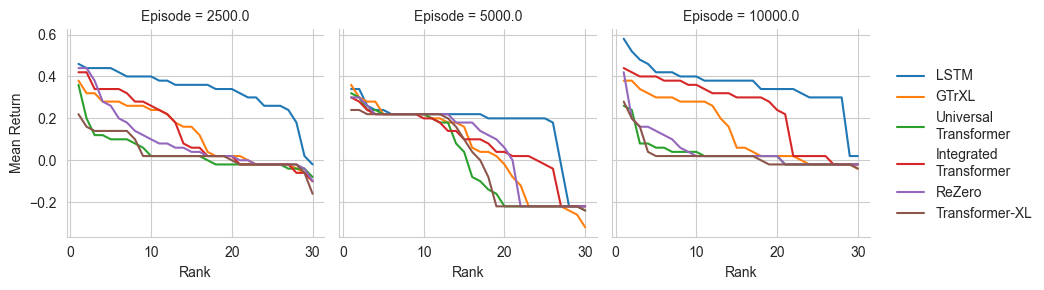

In [23]:
plt.show()

## Memory Size 9

In [24]:
envs = ["memory_size/9"]

In [25]:
experiments = get_experiments_df(
    memory_models,
    envs,
    seeds,
    save_dir="training",
    column_names=["Episode", "Average Score", "Loss"],
)

In [26]:
experiments = experiments[experiments.Episode.isin(episodes)]
experiments = experiments.sort_values(by=["Average Score"], axis=0, ascending=False)
experiments = experiments.groupby(["Episode", "Memory"]).apply(add_rank)
experiments.Memory = experiments.Memory.apply(lambda x: x.replace(" ", "\n"))
memory_models = ["LSTM", "GTrXL", "Universal\nTransformer", "Integrated\nTransformer", "ReZero"]

g = sns.FacetGrid(experiments, col="Episode", hue="Memory", hue_order=memory_order)
g.map_dataframe(sns.lineplot, x="Rank", y="Average Score")
g.set_axis_labels("Rank", "Mean Return")
g.add_legend(title="")
g.tight_layout()
# /Users/tommakkink/Code/transformers-for-rl/results/plots/training
env_name = envs[0].replace("/", "-")
g.savefig(f"results/plots/training/{env_name}_seed_analysis.png", dpi=300)

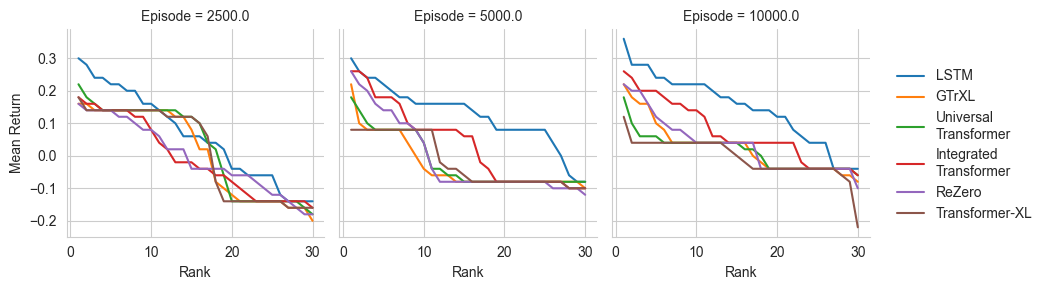

In [27]:
plt.show()